### Analyze the Spread of Novel CoronaVirus 
#### Data Source: [Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19)

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from os import walk

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import acf
from scipy import stats

#### Load all sheets in the underlying file

In [2]:
file_path = '../../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'

file_list = []
for (dirpath, dirnames, filenames) in walk(file_path):
    file_list.extend(filenames)
    break

file_list = [x for x in file_list if x[-3:] == 'csv']

In [3]:
##sheet = client.open('Learning Log').sheet1
raw_df = pd.DataFrame()
for file_name in file_list:
    sub_table = pd.read_csv(file_path + file_name)
    sub_table['sheet_name'] = file_name.split('.')[0]
    raw_df = pd.concat([raw_df, sub_table], sort=True)

raw_df.tail()

,Confirmed,Country/Region,Deaths,Last Update,Latitude,Longitude,Province/State,Recovered,sheet_name
250,0.0,Australia,0.0,2020-03-06T04:33:03,-12.4634,130.8456,Northern Territory,0.0,03-08-2020
251,0.0,US,0.0,2020-02-24T23:33:02,29.3829,-98.6134,"Lackland, TX (From Diamond Princess)",0.0,03-08-2020
252,0.0,US,0.0,2020-03-07T19:53:02,30.3213,-95.4778,"Montgomery County, TX",0.0,03-08-2020
253,0.0,US,0.0,2020-02-24T23:33:02,41.2545,-95.9758,"Omaha, NE (From Diamond Princess)",0.0,03-08-2020
254,0.0,US,0.0,2020-02-24T23:33:02,38.2721,-121.9399,"Travis, CA (From Diamond Princess)",0.0,03-08-2020


In [4]:
raw_df['Last Update'].max()

'2020-03-19T23:43:04'

In [5]:
# Merge duplicate columns with different names
main_df = raw_df

# main_df.loc[main_df.Deaths.isna(),'Deaths'] =  main_df.loc[main_df.Deaths.isna(),'Demised']

# main_df.loc[main_df['Country/Region'].isna(),'Country/Region'] =  main_df.loc[main_df['Country/Region'].isna(),'Country']
# main_df.loc[main_df['Country/Region'].isna(),'Country/Region'] =  main_df.loc[main_df['Country/Region'].isna(),'Country_Region']

# main_df.loc[main_df['Province/State'].isna(),'Province/State'] =  main_df.loc[main_df['Province/State'].isna(),'Province_State']

# main_df.loc[main_df['Last Update'].isna(),'Last Update'] = main_df.loc[main_df['Last Update'].isna(),'Date last updated']
#main_df.loc[main_df['Last Update (UTC)'].isna(),'Last Update (UTC)'] = main_df.loc[main_df['Last Update (UTC)'].isna(),'Last_Update']
#main_df.loc[main_df['Last Update'].isna(),'Last Update'] = main_df.loc[main_df['Last Update'].isna(),'Last Update (UTC)']

main_df.loc[main_df['Province/State'].isna(), 'Province/State'] = main_df.loc[main_df['Province/State'].isna(), 'Country/Region']
main_df.loc[main_df['Province/State']=='', 'Province/State'] = main_df.loc[main_df['Province/State']=='', 'Country/Region']
main_df.loc[main_df['Province/State']=='None', 'Province/State'] = main_df.loc[main_df['Province/State']=='None', 'Country/Region']

main_df = main_df.loc[:, ~main_df.columns.isin(['Demised' , 'Country' , 'Country_Region','Province_State',
                                                'Date last updated', 'Last Update (UTC)', 'Last_Update', '',
                                                'Quick note: Starting from this tab, our map is updating (almost) in real time (China data - at least once per hour; non China data - several times per day). This table is planning to be updated twice a day. The discrepancy between the map and this sheet is expected. Sorry for any confusion and inconvenience.'
                                                'Announcement'])]

## main_df = main_df.drop(columns=['Announcement',
                      ## 'Quick note: Starting from this tab, our map is updating (almost) in real time (China data - at least once per hour; non China data - several times per day). This table is planning to be updated twice a day. The discrepancy between the map and this sheet is expected. Sorry for any confusion and inconvenience.'])

main_df.sample(5)

,Confirmed,Country/Region,Deaths,Last Update,Latitude,Longitude,Province/State,Recovered,sheet_name
106,1.0,US,0.0,2020-02-05T21:53:02,NaN,NaN,"Madison, WI",0.0,02-28-2020
6,2078.0,Germany,3.0,2020-03-12T09:53:06,51.0000,9.0000,Germany,25.0,03-12-2020
73,1.0,Lebanon,0.0,2020-02-22T20:53:02,NaN,NaN,Lebanon,0.0,02-24-2020
85,6.0,Romania,0.0,2020-03-05T06:23:06,46.0000,25.0000,Romania,1.0,03-05-2020
60,75.0,China,0.0,2020-03-11T09:33:12,37.2692,106.1655,Ningxia,72.0,03-12-2020


In [6]:
main_df.sheet_name.str.split('-')

0      [02, 26, 2020]
1      [02, 26, 2020]
2      [02, 26, 2020]
3      [02, 26, 2020]
4      [02, 26, 2020]
            ...      
250    [03, 08, 2020]
251    [03, 08, 2020]
252    [03, 08, 2020]
253    [03, 08, 2020]
254    [03, 08, 2020]
Name: sheet_name, Length: 7014, dtype: object

In [7]:
# merge duplicate country names
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'^China','Mainland China')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'Taipei and environs','Taiwan')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'Taiwan\*','Taiwan')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'United States','US')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'United Kingdom','UK')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'Viet Nam','Vietnam')

main_df['Last Update'] = pd.to_datetime(main_df['Last Update'])
main_df['Last Update'] = main_df['Last Update'] - timedelta(hours=2) # to deal with cases reported too early on next day


main_df['month'] = main_df.sheet_name.str.split('-').apply(lambda x: x[0])
main_df['day'] = main_df.sheet_name.str.split('-').apply(lambda x: x[1])
#main_df['day'] = main_df['Last Update'].dt.day
#main_df['month'] = main_df['Last Update'].dt.month

main_df = main_df.fillna(0) # will take max value in the next step so it's OK (except for missing gaps)
main_df.Deaths.replace('',0, inplace=True)
main_df.Confirmed.replace('',0, inplace=True)
# main_df.Suspected.replace('',0, inplace=True)
main_df.Recovered.replace('',0, inplace=True)

main_df.loc[main_df['Province/State'] == 'Macau', 'Country/Region'] = 'Macau'
main_df.loc[main_df['Province/State'] == 'Hong Kong', 'Country/Region'] = 'Hong Kong'
main_df.loc[main_df['Province/State'] == 'Hong Kong','Country/Region'] = 'Hong Kong'

In [8]:
main_df.describe(include=np.object)

,Country/Region,Province/State,sheet_name,month,day
count,7014,7014,7014,7014,7014
unique,192,446,58,3,31
top,Mainland China,Gansu,03-19-2020,03,19
freq,1796,60,292,4196,368


In [9]:
clean_df =main_df.groupby(['Country/Region','Province/State','month','day']).agg({'Last Update':'max',
                                                                  'Confirmed':'max',
                                                                  ## 'Suspected':'max',
                                                                  'Recovered':'max',
                                                                  'Deaths':'max'}).reset_index()

clean_df['period'] = pd.to_datetime('2020-' + clean_df.month.astype(str) + '-' + clean_df.day.astype(str))
clean_df = clean_df.sort_values(['Country/Region','Province/State','period'])

clean_df

,Country/Region,Province/State,month,day,Last Update,Confirmed,Recovered,Deaths,period
0,Azerbaijan,Azerbaijan,02,28,2020-02-28 13:03:26,1.0,0.0,0.0,2020-02-28
1,Afghanistan,Afghanistan,02,24,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-24
2,Afghanistan,Afghanistan,02,25,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-25
3,Afghanistan,Afghanistan,02,26,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-26
4,Afghanistan,Afghanistan,02,27,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-27
...,...,...,...,...,...,...,...,...,...
7005,occupied Palestinian territory,occupied Palestinian territory,03,12,2020-03-11 18:53:02,0.0,0.0,0.0,2020-03-12
7006,occupied Palestinian territory,occupied Palestinian territory,03,14,2020-03-11 18:53:02,0.0,0.0,0.0,2020-03-14
7007,occupied Palestinian territory,occupied Palestinian territory,03,15,2020-03-11 18:53:02,0.0,0.0,0.0,2020-03-15
7008,occupied Palestinian territory,occupied Palestinian territory,03,16,2020-03-11 18:53:02,0.0,0.0,0.0,2020-03-16


#### Some baisc checks

2020-01-22 15:00:00    38
2020-01-23 15:00:00    46
2020-01-24 15:00:00    41
2020-01-25 15:00:00    44
2020-01-26 14:00:00    47
                       ..
2020-03-19 19:13:35     4
2020-03-19 19:13:40     3
2020-03-19 19:43:03     8
2020-03-19 21:43:03     1
2020-03-19 21:43:04    25
Name: Last Update, Length: 1704, dtype: int64

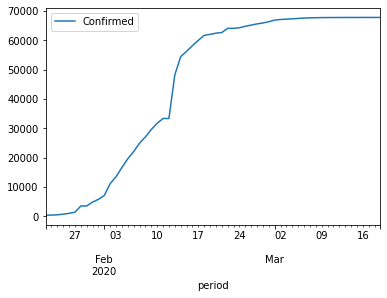

In [10]:
clean_df[clean_df['Province/State'] =='Hubei'].plot.line(x='period', y='Confirmed')
# clean_df[clean_df['Province/State'] =='Hubei']
clean_df['Last Update'].value_counts().sort_index()

In [11]:
clean_df['Province/State'].value_counts().sort_values().head(20)

Chicago                    1
Queens County, NY          1
Fiji                       1
Republic of Ireland        1
Norwell County, MA         1
Spartanburg County, SC     1
Cherokee County, GA        1
Chad                       1
Nicaragua                  1
Fench Guiana               1
Russian Federation         1
Shasta County, CA          1
North Ireland              1
Ashland, NE                1
Lackland, TX               1
Bermuda                    1
Santa Cruz County, CA      1
Unassigned Location, VT    1
Johnson County, IA         1
Ivory Coast                1
Name: Province/State, dtype: int64

In [12]:
clean_df['Province/State'].value_counts().sort_values().head(10).index

Index(['Chicago', 'Queens County, NY', 'Fiji', 'Republic of Ireland',
       'Norwell County, MA', 'Spartanburg County, SC', 'Cherokee County, GA',
       'Chad', 'Nicaragua', 'Fench Guiana'],
      dtype='object')

### Some Analysis on virus spread

##### Growth rate of confirmed cases

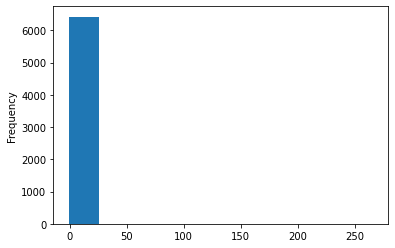

In [13]:
clean_df['Confirmed_lag'] = clean_df.groupby(['Province/State']).Confirmed.shift(1)

clean_df['growth number daily'] =  clean_df.Confirmed - clean_df.Confirmed_lag

clean_df['growth rate daily'] = clean_df.Confirmed / clean_df.Confirmed_lag - 1

clean_df[clean_df.Confirmed_lag > 0]['growth rate daily'].plot.hist()

#### Drop province/state with multiple regions

In [14]:
state_count = clean_df.groupby('Province/State')['Country/Region'].nunique().sort_values(ascending=False).reset_index()
state_count
clean_state = state_count.loc[state_count['Country/Region']==1,'Province/State'].to_list()
clean_df = clean_df[clean_df['Province/State'].isin(clean_state)]

In [15]:
clean_df[clean_df['growth rate daily']<0]

,Country/Region,Province/State,month,day,Last Update,Confirmed,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily
222,Australia,Northern Territory,03,06,2020-03-06 02:33:03,0.0,0.0,0.0,2020-03-06,1.0,-1.0,-1.000000
237,Australia,Queensland,01,31,2020-01-31 21:59:00,2.0,0.0,0.0,2020-01-31,3.0,-1.0,-0.333333
239,Australia,Queensland,02,02,2020-02-02 20:33:07,2.0,0.0,0.0,2020-02-02,3.0,-1.0,-0.333333
464,Azerbaijan,Azerbaijan,03,16,2020-03-16 12:38:45,15.0,6.0,1.0,2020-03-16,23.0,-8.0,-0.347826
487,Bahrain,Bahrain,03,13,2020-03-11 18:00:00,189.0,44.0,0.0,2020-03-13,195.0,-6.0,-0.030769
1574,Guernsey,Guernsey,03,17,2020-03-17 16:33:03,0.0,0.0,0.0,2020-03-17,1.0,-1.0,-1.000000
1938,Japan,Japan,01,23,2020-01-23 15:00:00,1.0,0.0,0.0,2020-01-23,2.0,-1.0,-0.500000
1953,Japan,Japan,02,07,2020-02-07 02:13:20,25.0,1.0,0.0,2020-02-07,45.0,-20.0,-0.444444
1991,Japan,Japan,03,16,2020-03-16 12:38:45,825.0,144.0,27.0,2020-03-16,839.0,-14.0,-0.016687
1998,Jersey,Jersey,03,17,2020-03-17 16:33:03,0.0,0.0,0.0,2020-03-17,2.0,-2.0,-1.000000


In [68]:
# focus on cases where base is above 20
heavy_affect_df = clean_df[clean_df['Confirmed_lag'] >= 30]

heavy_affect_df['day count'] = heavy_affect_df.groupby('Province/State')['period'].rank()

heavy_affect_df.describe()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Confirmed,Recovered,Deaths,Confirmed_lag,growth number daily,growth rate daily,recover rate,day count
count,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000
mean,1614.529659,610.864906,54.528129,1525.191734,89.337926,0.133830,0.340484,18.558362
std,7924.405934,4226.755953,338.710574,7760.256613,479.698838,0.226884,0.366532,15.310472
min,25.000000,0.000000,0.000000,30.000000,-62.000000,-0.444444,0.000000,1.000000
25%,85.000000,3.000000,0.000000,75.000000,0.000000,0.000000,0.017647,5.000000
50%,176.000000,32.000000,1.000000,168.000000,5.000000,0.034483,0.162500,14.000000
75%,542.000000,170.000000,4.000000,525.000000,27.000000,0.192537,0.692913,30.000000
max,67800.000000,57682.000000,3405.000000,67800.000000,14840.000000,3.024096,1.000000,57.000000


In [17]:
# growth_df[growth_df.isna().sum(axis=1) <= growth_df.isna().sum(axis=1).shift(-1)]

In [18]:
growth_df = heavy_affect_df.\
    pivot_table(values = 'growth rate daily', index = 'day count', columns='Province/State').\
    reset_index()

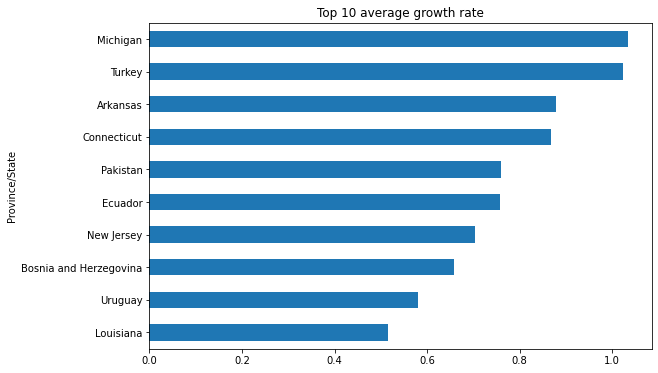

In [71]:
# arithmatic mean of growth rate
growth_df.set_index('day count').mean().\
    sort_values().iloc[-10:].plot.barh(figsize=(9,6),title='Top 10 average growth rate')

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/anaconda3/envs/py37/lib/python

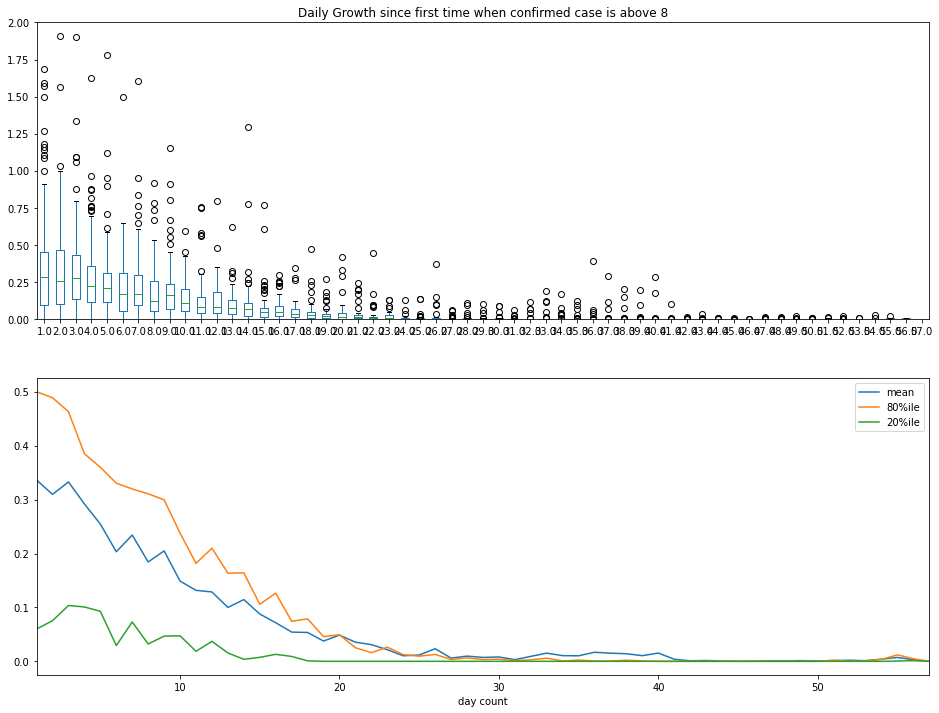

In [22]:
figure, axes = plt.subplots(nrows=2, ncols=1, figsize =(16,12))

growth_df.set_index('day count').transpose().plot.box(ax = axes[0], 
                                         title ='Daily Growth since first time when confirmed case is above 8',
                                         ylim =(0, 2))

# deceleration? caveat: ommision bias
growth_df.set_index('day count').mean(axis =1).plot(ax = axes[1])
growth_df.set_index('day count').quantile(q=0.8, axis =1).plot(ax = axes[1])
growth_df.set_index('day count').quantile(q=0.2, axis =1).plot(ax = axes[1])

axes[1].legend(['mean','80%ile','20%ile'])

In [23]:
# cumulative growth rate from base of the first time there is more than 8 "confirmed case"
earliest_df = heavy_affect_df. \
            groupby(['Province/State']). \
            agg({'Confirmed':'min'}).reset_index().rename(columns ={'Confirmed': 'base'})

earliest_df.sort_values(by='base',ascending=False).head()

,Province/State,base
74,"Korea, South",7869.0
150,United Kingdom,1140.0
53,Hubei,444.0
157,Washington,366.0
112,Qatar,262.0


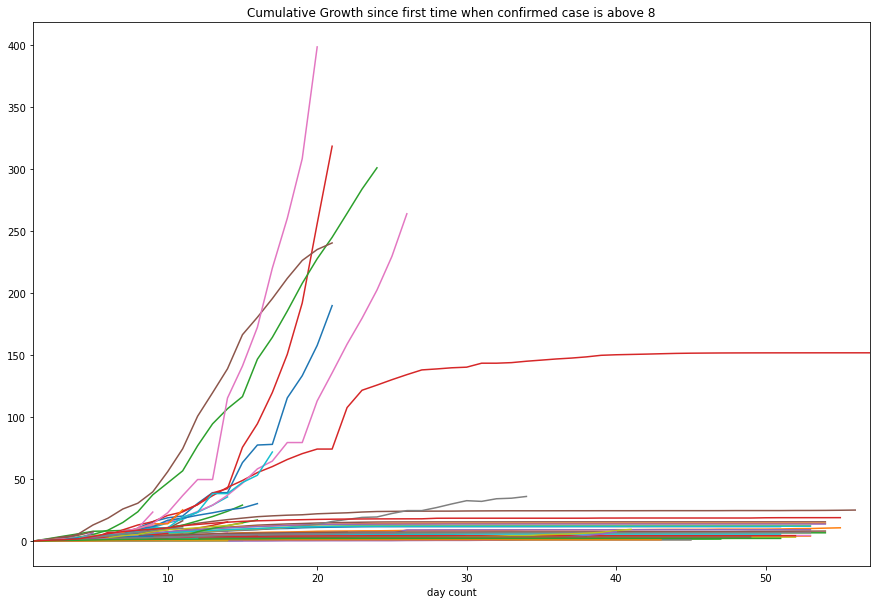

In [69]:
heavy_affect_df = pd.merge(heavy_affect_df, earliest_df, how = 'left', left_on = 'Province/State', right_on = 'Province/State')

heavy_affect_df['cumulative growth'] = heavy_affect_df['Confirmed']/ heavy_affect_df['base'] - 1
cmlt_growth_df = heavy_affect_df.pivot_table(columns ='Province/State', index= 'day count', values='cumulative growth')

cmlt_growth_df.plot.line(figsize =(15, 10), 
                         title ='Cumulative Growth since first time when confirmed case is above 8',
                         legend = False)

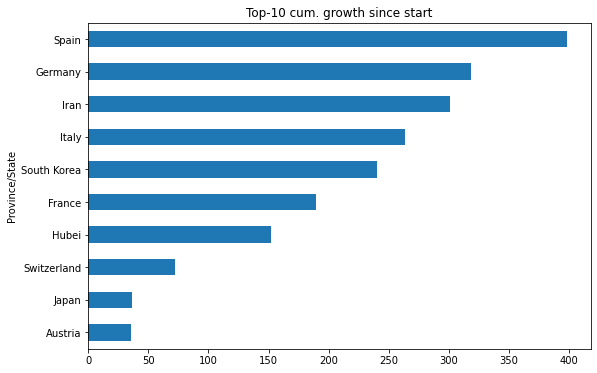

In [70]:
cmlt_growth_df.max().sort_values().iloc[-10:].plot.barh(figsize =(9,6), title='Top-10 cum. growth since start')

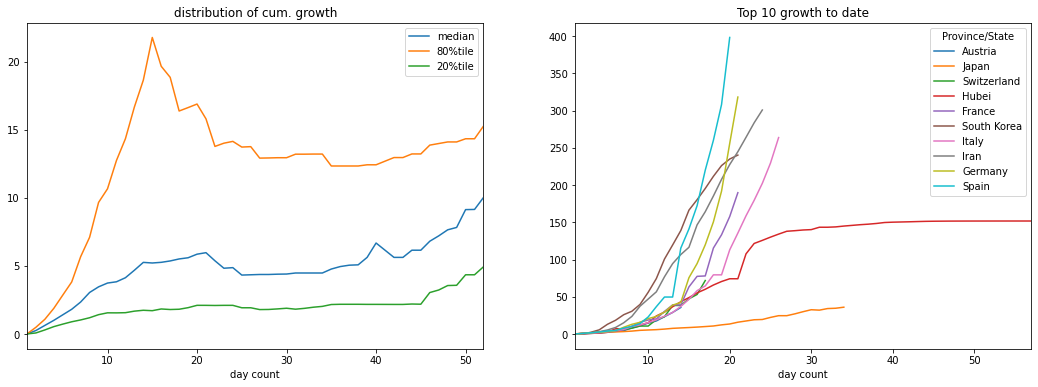

In [29]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(18,6))

# deceleration? (caveat: ommited variable)
cmlt_growth_df.iloc[:-5,:].median(axis=1).plot(ax = axes[0])
cmlt_growth_df.iloc[:-5,:].quantile(q=0.8,axis=1).plot(ax = axes[0])
cmlt_growth_df.iloc[:-5,:].quantile(q=0.2,axis=1).plot(ax = axes[0], title ='distribution of cum. growth')

axes[0].legend(['median','80%tile', '20%tile'])

# the following provinces/states have the top 10 cumulative growth
cmlt_growth_df[cmlt_growth_df.max().sort_values().index.tolist()[-10:]].plot.line(ax =axes[1],  
                                                                                  title = 'Top 10 growth to date')

#### Compare China vs. Outside

In [30]:
# focus on countries outside of China
outside_df = clean_df[clean_df['Country/Region']!= 'Mainland China']

outside_agg_df = outside_df.groupby(['Country/Region','Province/State','period']). \
    agg({'Confirmed':'max','Recovered':'max','Deaths':'max'}).reset_index(). \
    groupby(['period']). \
    agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum','Province/State':'count'}).reset_index()

## outside_agg_df['Confirmed lag'] = outside_agg_df.Confirmed.shift(1)

outside_agg_df['log_growth'] = np.log(outside_agg_df.Confirmed).diff()

In [31]:
china_df = clean_df[clean_df['Country/Region']=='Mainland China']

china_agg_df = china_df.groupby(['Country/Region','Province/State','period']). \
    agg({'Confirmed':'max','Recovered':'max','Deaths':'max'}).reset_index(). \
    groupby(['period']). \
    agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum','Province/State':'count'}).reset_index()

china_agg_df['log_growth'] = np.log(china_agg_df.Confirmed).diff()

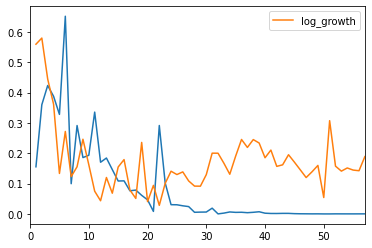

In [32]:
china_agg_df.log_growth.plot()
outside_agg_df.log_growth.plot(legend = True)

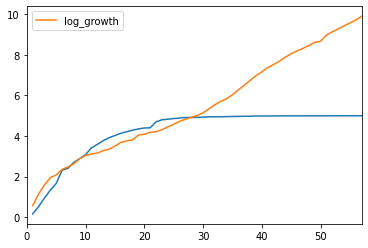

In [33]:
# cumulative growth
china_agg_df.log_growth.cumsum().plot()
outside_agg_df.log_growth.cumsum().plot(legend=True)

In [34]:
# The null hypothesis that the two distribution the same is reject by a simple T-test
# Looking closely, the deviation occurs after day 30. This could be due to effectivenss
stats.ttest_ind(china_agg_df.log_growth.dropna(), outside_agg_df.log_growth.dropna())

Ttest_indResult(statistic=-3.6978478583554653, pvalue=0.000338436046696645)

#### Time-series Analysis on Growth Rate

In [35]:
# auto-correlation is high in China 🇨🇳  on aggregate
print(acf(china_agg_df['log_growth'].dropna()))

# this consistent with AR test, whose lag is not significant
model = AutoReg(china_agg_df['log_growth'].dropna(), lags=1) # unable to run VAR due to missing values (synthetic control?)
results = model.fit()
results.summary()

[ 1.          0.67863493  0.70101107  0.61867528  0.51415122  0.48415995
  0.39024236  0.37074563  0.34130309  0.29748926  0.22846374  0.21297502
  0.15279092  0.09909259  0.09629944  0.01271203  0.11647035  0.04965388
  0.02190286  0.02163922  0.00214699 -0.06135243 -0.10911506 -0.12437694
 -0.14075734 -0.1468575  -0.1651924  -0.17131783 -0.17653252 -0.18598026
 -0.19506738 -0.20079958 -0.20556689 -0.20967061 -0.21665194 -0.21655697
 -0.20103599 -0.20870799 -0.21342217 -0.21654165 -0.21766767]


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             log_growth   No. Observations:                   57
Model:                     AutoReg(1)   Log Likelihood                  48.698
Method:               Conditional MLE   S.D. of innovations              0.101
Date:                Fri, 20 Mar 2020   AIC                             -4.470
Time:                        22:13:33   BIC                             -4.361
Sample:                             1   HQIC                            -4.428
                                   57                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0255      0.016      1.579      0.114      -0.006       0.057
log_growth.L1     0.6836      0.098      6.991      0.000       0.492       0.875
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4628           +0.0000j            1.4628            0.0000
-----------------------------------------------------------------------------
"""

In [31]:
# auto-correlation is quite high outside of China
print(acf(outside_agg_df['log_growth'].dropna()))

# this consistent with AR test, whose lag is significant
model = AutoReg(outside_agg_df['log_growth'].dropna(), lags=1) # unable to run VAR due to missing values (synthetic control?)
results = model.fit()
results.summary()

[ 1.          0.58804196  0.41044849  0.23387674  0.10888675  0.12876263
  0.08844528  0.09711402  0.00641327 -0.10328368 -0.12871321 -0.15930112
 -0.09461761 -0.06167556 -0.10652811 -0.07466446 -0.14682969 -0.11200838
 -0.1401717  -0.23351268 -0.17412933 -0.17655326 -0.09367489 -0.09729749
 -0.13480419 -0.12625664 -0.14571857 -0.1133008  -0.05374252 -0.00266136
  0.04667541 -0.03290651  0.04701165  0.02687543  0.08571853  0.15274052
  0.12547039  0.08547488  0.06850477  0.00771909 -0.00573115]


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             log_growth   No. Observations:                   52
Model:                     AutoReg(1)   Log Likelihood                  61.164
Method:               Conditional MLE   S.D. of innovations              0.073
Date:                Sun, 15 Mar 2020   AIC                             -5.119
Time:                        08:58:57   BIC                             -5.005
Sample:                             1   HQIC                            -5.075
                                   52                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0646      0.019      3.402      0.001       0.027       0.102
log_growth.L1     0.5886      0.091      6.478      0.000       0.410       0.767
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6991           +0.0000j            1.6991            0.0000
-----------------------------------------------------------------------------
"""

#### Predictive Models for Singapore

In [36]:
outside_df.groupby(['Country/Region','Province/State','period']). \
    agg({'Confirmed':'max','Recovered':'max','Deaths':'max'}).reset_index()

,Country/Region,Province/State,period,Confirmed,Recovered,Deaths
0,Azerbaijan,Azerbaijan,2020-02-28,1.0,0.0,0.0
1,Afghanistan,Afghanistan,2020-02-24,1.0,0.0,0.0
2,Afghanistan,Afghanistan,2020-02-25,1.0,0.0,0.0
3,Afghanistan,Afghanistan,2020-02-26,1.0,0.0,0.0
4,Afghanistan,Afghanistan,2020-02-27,1.0,0.0,0.0
...,...,...,...,...,...,...
4960,occupied Palestinian territory,occupied Palestinian territory,2020-03-12,0.0,0.0,0.0
4961,occupied Palestinian territory,occupied Palestinian territory,2020-03-14,0.0,0.0,0.0
4962,occupied Palestinian territory,occupied Palestinian territory,2020-03-15,0.0,0.0,0.0
4963,occupied Palestinian territory,occupied Palestinian territory,2020-03-16,0.0,0.0,0.0


#### Apply econometric model given 1) small dataset and 2) preference for confidence interval

In [37]:
model_df = growth_df[growth_df.index <= growth_df[growth_df['Singapore'].isna() == False].index.max()].\
    set_index('day count')
model_df = model_df.dropna(axis=1)
model_df

Province/State,Anhui,Beijing,Chongqing,Fujian,Gansu,Guangdong,Guangxi,Guizhou,Hainan,Hebei,...,Shaanxi,Shandong,Shanghai,Shanxi,Sichuan,Singapore,Tianjin,Xinjiang,Yunnan,Zhejiang
day count,,,,,,,,,,,,,,,,,,,,,
1.0,0.538462,0.138889,0.315789,0.685714,0.275000,0.656250,0.277778,0.210526,0.212121,0.454545,...,0.314286,0.630435,0.212121,0.114286,0.568182,0.100000,0.032258,0.125000,0.250000,0.441860
2.0,0.166667,0.658537,0.466667,0.355932,0.078431,0.471698,0.108696,0.260870,0.075000,0.354167,...,0.217391,0.266667,0.325000,0.205128,0.304348,0.212121,0.281250,0.083333,0.272727,0.677419
3.0,0.514286,0.176471,0.200000,0.050000,0.036364,0.423077,0.137255,0.103448,0.069767,0.261538,...,0.125000,0.368421,0.245283,0.404255,0.200000,0.125000,0.170732,0.076923,0.185714,0.230769
4.0,0.433962,0.137500,0.113636,0.202381,0.087719,0.360360,0.344828,0.109375,0.130435,0.170732,...,0.380952,0.215385,0.454545,0.121212,0.314815,0.044444,0.250000,0.071429,0.120482,0.351562
5.0,0.315789,0.219780,0.238095,0.188119,0.000000,0.370861,0.115385,0.140845,0.192308,0.083333,...,0.160920,0.164557,0.166667,0.094595,0.246479,0.063830,0.116667,0.088889,0.129032,0.710983
6.0,0.185000,0.027027,0.159341,0.200000,0.080645,0.338164,0.149425,0.098765,0.032258,0.086538,...,0.148515,0.119565,0.205357,0.000000,0.169492,0.160000,0.029851,0.122449,0.114286,0.445946
7.0,0.253165,0.219298,0.170616,0.104167,0.179104,0.277978,0.110000,0.112360,0.125000,0.115044,...,0.103448,0.116505,0.251852,0.185185,0.115942,0.155172,0.144928,0.072727,0.042735,0.257009
8.0,0.144781,0.208633,0.214575,0.125786,0.050633,0.231638,0.144144,0.101010,0.111111,0.071429,...,0.109375,0.126087,0.076923,0.083333,0.099567,0.074627,0.025316,0.067797,0.049180,0.113383
9.0,0.200000,0.136905,0.123333,0.083799,0.000000,0.227064,0.094488,0.165138,0.237500,0.162963,...,0.161972,0.061776,0.115385,0.105769,0.110236,0.041667,0.086420,0.031746,0.039062,0.103506


In [38]:
model_df.corr()['Singapore'].sort_values(ascending=False).head(10)

Province/State
Singapore         1.000000
Chongqing         0.465522
Inner Mongolia    0.456478
Guizhou           0.455264
Zhejiang          0.446977
Jilin             0.443929
Yunnan            0.428961
Xinjiang          0.420366
Beijing           0.416145
Jiangsu           0.413026
Name: Singapore, dtype: float64

In [39]:
var_model = VAR(model_df[['Singapore','Chongqing']])
results = var_model.fit(maxlags=1)
results.summary()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 20, Mar, 2020
Time:                     22:16:38
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.4596
Nobs:                     40.0000    HQIC:                  -11.6213
Log likelihood:           126.743    FPE:                8.19191e-06
AIC:                     -11.7129    Det(Omega_mle):     7.08872e-06
--------------------------------------------------------------------
Results for equation Singapore
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.034785         0.011811            2.945           0.003
L1.Singapore         0.289552         0.164706            1.758           0.079
L1.Chongqing         0.142683         0.087277            1.

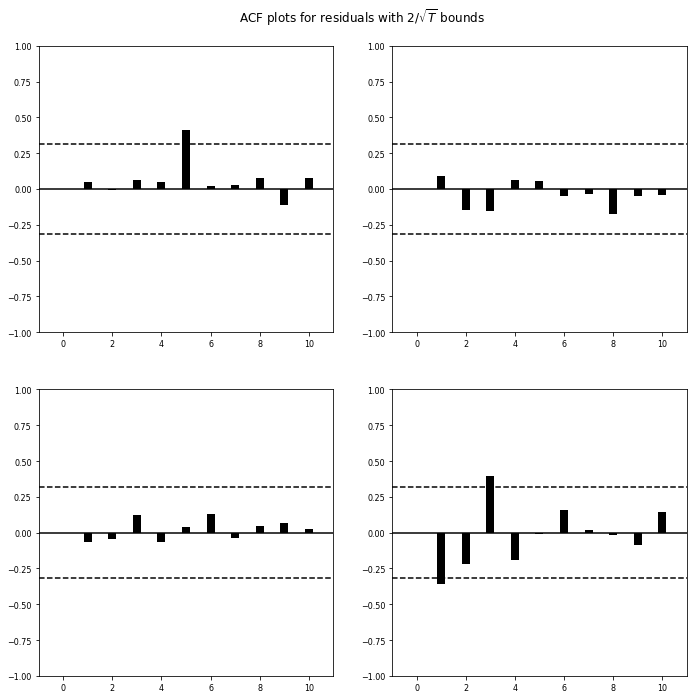

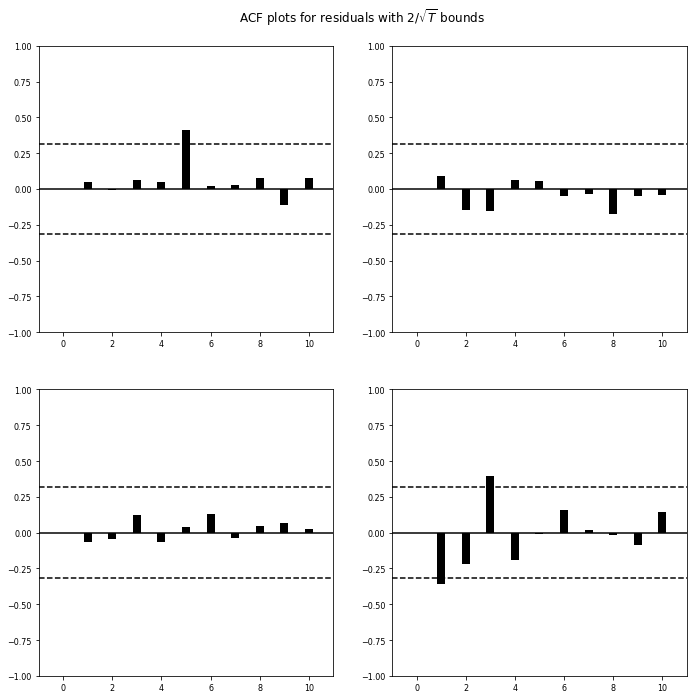

In [40]:
results.plot_acorr()

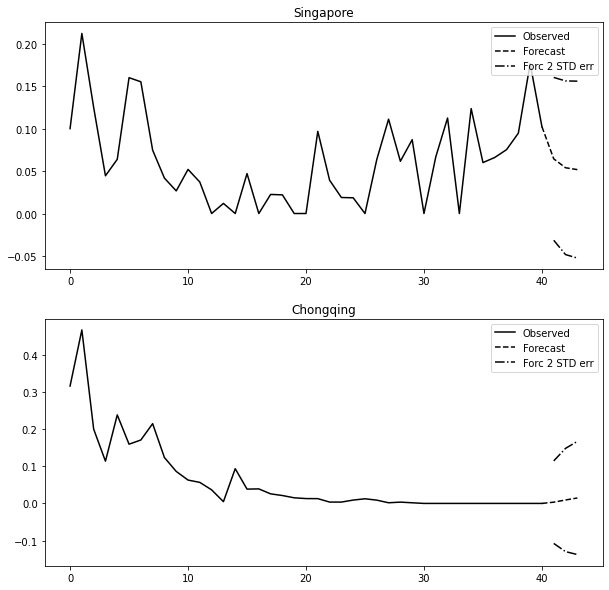

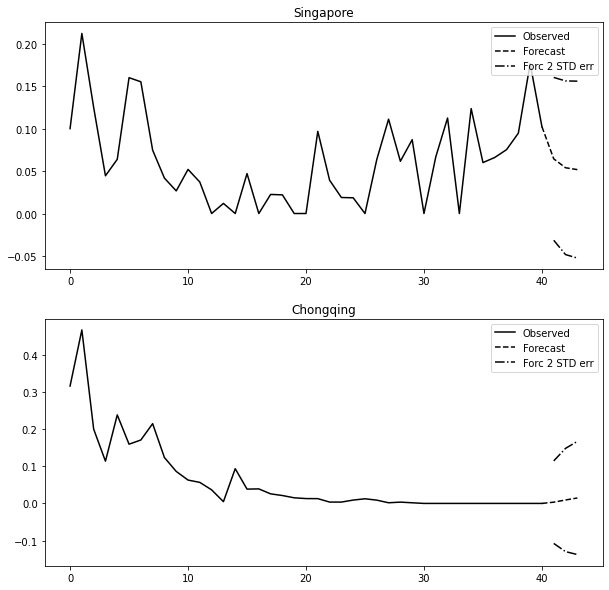

In [41]:
# Make forecast
results.plot_forecast(3)

In [42]:
# model_df[['Singapore','Hong Kong']]

# fcst_df

# fcst_df.loc[10,['Singapore','Hong Kong']].values

# np.array(fcst)

# np.array(fcst).flatten()

In [43]:
# day to be forecasted
day_forecat = model_df.index.max() + 1

In [44]:
fcst = results.forecast_interval(model_df[['Singapore','Chongqing']].values[-2:,:], 1)

In [45]:
fcst_df = heavy_affect_df[heavy_affect_df['Province/State'].isin(['Singapore','Chongqing'])].pivot(index ='day count',
                                                                                         columns = 'Province/State',
                                                                                        values = 'Confirmed')

In [46]:
fcst_num = ((np.array(fcst) + 1 ) * fcst_df.loc[day_forecat-1,['Singapore','Chongqing']].values).flatten()

In [47]:
fcst_df['Singapore_f_m'] = np.nan
fcst_df['Chongqing_f_m'] = np.nan
fcst_df['Singapore_f_lo'] = np.nan
fcst_df['Chongqing_f_lo'] = np.nan
fcst_df['Singapore_f_up'] = np.nan
fcst_df['Chongqing_f_up'] = np.nan

fcst_df.loc[day_forecat,['Singapore_f_m','Chongqing_f_m','Singapore_f_lo',
                'Chongqing_f_lo','Singapore_f_up','Chongqing_f_up']] = fcst_num

fcst_df.loc[day_forecat - 1, ['Singapore_f_m','Singapore_f_lo','Singapore_f_up']] = fcst_df.loc[day_forecat - 1,'Singapore']
fcst_df.loc[day_forecat - 1, ['Chongqing_f_m','Chongqing_f_lo','Chongqing_f_up']] = fcst_df.loc[day_forecat - 1,'Chongqing']

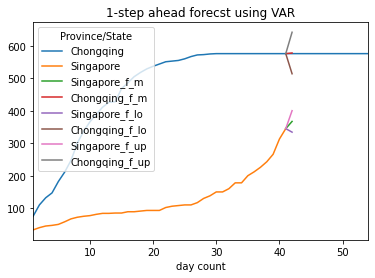

In [48]:
fcst_df.plot.line(title = '1-step ahead forecst using VAR')

#### The above model stopped working after correlations are broken due to government intervention. 
#### Alternative Model with Global Contagion

In [82]:
clean_df['log_confirmed'] = np.log(clean_df.Confirmed)
model_2_df = clean_df.pivot_table(index = ['month','day'], columns='Province/State',values='log_confirmed').reset_index()
model_2_df = model_2_df[model_2_df.month>='03']
model_2_df = model2_df.dropna(axis=1)
model_2_df.columns

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Index(['month', 'day', 'Afghanistan', 'Algeria', 'Anhui', 'Armenia', 'Austria',
       'Azerbaijan', 'Bahrain', 'Beijing', 'Belarus', 'Belgium', 'Brazil',
       'British Columbia', 'Cambodia', 'Chongqing', 'Croatia', 'Denmark',
       'Dominican Republic', 'Ecuador', 'Egypt', 'Estonia', 'Finland',
       'France', 'Fujian', 'Gansu', 'Germany', 'Greece', 'Guangdong',
       'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan',
       'Hong Kong', 'Hubei', 'Hunan', 'Iceland', 'India', 'Inner Mongolia',
       'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan', 'Jiangsu', 'Jiangxi',
       'Jilin', 'Kuwait', 'Lebanon', 'Liaoning', 'Lithuania', 'Luxembourg',
       'Macau', 'Malaysia', 'Mexico', 'Monaco', 'Nepal', 'Netherlands',
       'New South Wales', 'New Zealand', 'Nigeria', 'Ningxia',
       'North Macedonia', 'Norway', 'Oman', 'Pakistan', 'Philippines', 'Qatar',
       'Qinghai', 'Queensland', 'Romania', 'San Marino', 'Shaanxi', 'Shandong',
       'Shanghai', 'Shanxi', 'Sich

In [86]:
var_2_model = VAR(model_2_df[['Singapore','Hubei','Japan','Philippines','Thailand','Italy','Germany']])
results_2 = var_2_model.fit(maxlags=1)
results_2.summary()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 20, Mar, 2020
Time:                     22:58:19
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -48.7604
Nobs:                     18.0000    HQIC:                  -51.1485
Log likelihood:           340.988    FPE:                6.65475e-23
AIC:                     -51.5305    Det(Omega_mle):     5.07254e-24
--------------------------------------------------------------------
Results for equation Singapore
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const               -234.451813       148.370392           -1.580           0.114
L1.Singapore           0.248901         0.275271            0.904           0.366
L1.Hubei              21.536007        13.472721    

### Global recover and mortality rate using the latest data available

In [49]:
clean_df['recover rate'] = clean_df.Recovered / clean_df.Confirmed
latest_df = clean_df.groupby(['Province/State']).agg({'Last Update': 'max'}).reset_index()

latest_df = pd.merge(clean_df, latest_df, how = 'right', left_on = ['Province/State', 'Last Update'], right_on = ['Province/State', 'Last Update'])
latest_df

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Country/Region,Province/State,month,day,Last Update,Confirmed,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily,recover rate
0,Azerbaijan,Azerbaijan,02,28,2020-02-28 13:03:26,1.0,0.0,0.0,2020-02-28,NaN,NaN,NaN,0.000000
1,Afghanistan,Afghanistan,03,17,2020-03-17 09:53:10,22.0,1.0,0.0,2020-03-17,21.0,1.0,0.047619,0.045455
2,Afghanistan,Afghanistan,03,18,2020-03-17 09:53:10,22.0,1.0,0.0,2020-03-18,22.0,0.0,0.000000,0.045455
3,Afghanistan,Afghanistan,03,19,2020-03-17 09:53:10,22.0,1.0,0.0,2020-03-19,22.0,0.0,0.000000,0.045455
4,Albania,Albania,03,19,2020-03-19 09:33:30,64.0,0.0,2.0,2020-03-19,59.0,5.0,0.084746,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,occupied Palestinian territory,occupied Palestinian territory,03,12,2020-03-11 18:53:02,0.0,0.0,0.0,2020-03-12,0.0,0.0,NaN,NaN
1011,occupied Palestinian territory,occupied Palestinian territory,03,14,2020-03-11 18:53:02,0.0,0.0,0.0,2020-03-14,0.0,0.0,NaN,NaN
1012,occupied Palestinian territory,occupied Palestinian territory,03,15,2020-03-11 18:53:02,0.0,0.0,0.0,2020-03-15,0.0,0.0,NaN,NaN
1013,occupied Palestinian territory,occupied Palestinian territory,03,16,2020-03-11 18:53:02,0.0,0.0,0.0,2020-03-16,0.0,0.0,NaN,NaN


Recovery over total confirmed cases: 40.76%


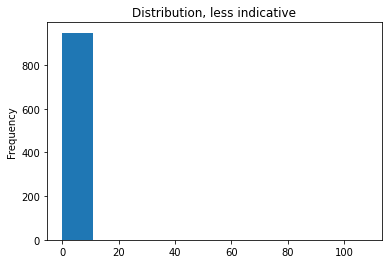

In [50]:
# Recovery rate
latest_df['recover rate'].plot.hist(title = 'Distribution, less indicative') # not much meaningful data is biased by many cases with very few confirmed case
print('Recovery over total confirmed cases: {0:.2%}'.format(latest_df.Recovered.sum() / latest_df.Confirmed.sum())) # ratio overall is more indicative

Mortality over total confirmed cases: 3.43%


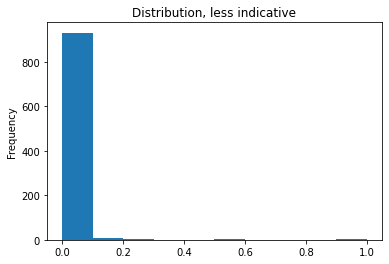

In [51]:
# Mortality rate
latest_df['mortality rate'] = latest_df.Deaths / latest_df.Confirmed
latest_df['mortality rate'].plot.hist(title = 'Distribution, less indicative') # not much meaningful data is biased by many cases with very few confirmed case
print('Mortality over total confirmed cases: {0:.2%}'.format(latest_df.Deaths.sum() / latest_df.Confirmed.sum())) # ratio overall is more indicative

### ***Retired-*** 

In [48]:
# #### Alternative method choose worksheet before merging (read from Excel manually downloaded)

# file_path = 'Novel Coronavirus (2019-nCoV) Cases, provided by JHU CSSE.xlsx'
# # raw_df = pd.concat(pd.read_excel(file_path, sheet_name= None), ignore_index = True, sort=True)

# xl = pd.ExcelFile(file_path)
# xl.sheet_names

# # use the latest time for each date
# split_name_df = pd.DataFrame(data = list(map(lambda x: x.split('_'), xl.sheet_names)), columns =['date','hour'])
# split_name_df

# # extract time components
# split_name_df['suffix'] = split_name_df.hour.apply(lambda x: x[-2:])

# split_name_df['hour_digit'] = split_name_df.hour.str.extract(r'(?P<hour>[\d]+)')

# split_name_df['date_digit'] = split_name_df.date.str.extract('([\d]+)').astype(int)

# # deal with special case of 12am and half-hour

# split_name_df.loc[split_name_df.hour == '12am', 'date_digit'] = split_name_df.loc[split_name_df.hour == '12am', 'date_digit'] - 1

# split_name_df['hour_digit'] = split_name_df.hour_digit.str.replace('30','').astype(int)

# split_name_df.loc[split_name_df.hour == '12am', 'hour_digit'] = 24

# split_name_df.loc[split_name_df.hour == '12am', 'suffix'] = 'pm'

# # filter for the last file for each day

# filter_name_df = split_name_df[split_name_df.suffix == 'pm']

# filter_name_df = filter_name_df.groupby('date_digit').agg({'hour_digit':'max','suffix': 'max'}).reset_index()

# filter_name_df

# filter_name_df = pd.merge(split_name_df,filter_name_df, how = 'right', 
#          left_on = ['date_digit', 'hour_digit','suffix'], right_on = ['date_digit','hour_digit','suffix'])

# filter_name = (filter_name_df.date + '_' + filter_name_df.hour).to_list()
# filter_name

# main_2_df = pd.concat(pd.read_excel(file_path, sheet_name= filter_name), ignore_index = True)
# main_2_df['Last Update'].value_counts()

In [49]:
# def read_excel_sheets(xls_path):
#     """Read all sheets of an Excel workbook and return a single DataFrame"""
#     print(f'Loading {xls_path} into pandas')
#     xl = pd.ExcelFile(xls_path)
#     df = pd.DataFrame()
#     columns = None
#     for idx, name in enumerate(xl.sheet_names):
#         print(f'Reading sheet #{idx}: {name}')
#         sheet = xl.parse(name)
#         if idx == 0:
#             # Save column names from the first sheet to match for append
#             columns = sheet.columns
#         sheet.columns = columns
#         # Assume index of existing data frame when appended
#         df = df.append(sheet, ignore_index=True)
#     return df

# read_excel_sheets(file_name)